In [1]:
import os
import re
import numpy as np            
import pandas as pd           
import scanpy as sc
import bbknn
import matplotlib.pyplot as plt
sc.set_figure_params(dpi=100, color_map='viridis', fontsize=6)
sc.settings.verbosity=2
sc.settings.n_jobs=16
sc.logging.print_versions()

stype = "CD8"
oDir = os.path.abspath("./OUT_FigS24")

if not os.path.exists(oDir):
    os.makedirs(oDir)
os.chdir(oDir)

In [2]:
adata = sc.read(f"{oDir}/../../data/expression/{stype}/integration/{stype}.expr.txt.gz", delimiter="\t",first_column_names=True)

Only considering the two last: ['.txt', '.gz'].
Only considering the two last: ['.txt', '.gz'].


In [3]:
## add cellInfo
cellInfo = pd.read_csv(f"{oDir}/../../data/metaInfo/{stype}.miniInfo.txt.gz", compression="gzip", sep="\t", header=0, index_col=0)
cellInfo = cellInfo.loc[list(adata.obs_names), [not bool(re.match('RNA_', i)) for i in cellInfo.columns] ]
adata.obs = cellInfo
#
adata.obs['cancerType'] = [re.sub('\\..*', '', i) for i in np.array(adata.obs.dataset)]

In [4]:
## add reduction (and subset)
redim1 = pd.read_csv(f"{oDir}/../../data/metaInfo/{stype}_Tex.pca.txt.gz", compression="gzip", sep="\t", header=0, index_col=0)
over = list(set(redim1.index) & set(adata.obs_names))
adata=adata[over,]
redim1 = redim1.loc[over, :]
#
adata.obsm['X_pca'] = np.array(redim1)

In [5]:
## add colSet
adata.obs["meta.cluster"] = adata.obs["meta.cluster"].astype('category')
color = pd.read_csv(f"{oDir}/../../data/metaInfo/color_meta.cluster_.txt.gz", compression='gzip', sep="\t", header=None, index_col=0)
color_used = list(color.loc[adata.obs["meta.cluster"].cat.categories,1])
adata.uns['meta.cluster_colors'] = color_used

# Run

In [6]:
sc.pp.neighbors(adata, n_pcs=15)

computing neighbors
    using 'X_pca' with n_pcs = 15
    finished (0:00:03)


In [7]:
## diffusion map
sc.tl.diffmap(adata, n_comps=10)

computing Diffusion Maps using n_comps=10(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.98471063 0.9763905  0.9558338  0.9511124  0.9397513
     0.92929035 0.92588896 0.9212616  0.9187851 ]
    finished (0:00:00)


... storing 'dataset' as categorical
... storing 'dataset.tech' as categorical
... storing 'ClusterID.pca' as categorical
... storing 'ClusterID.harmony' as categorical
... storing 'meta.cluster.coarse' as categorical
... storing 'cancerType' as categorical


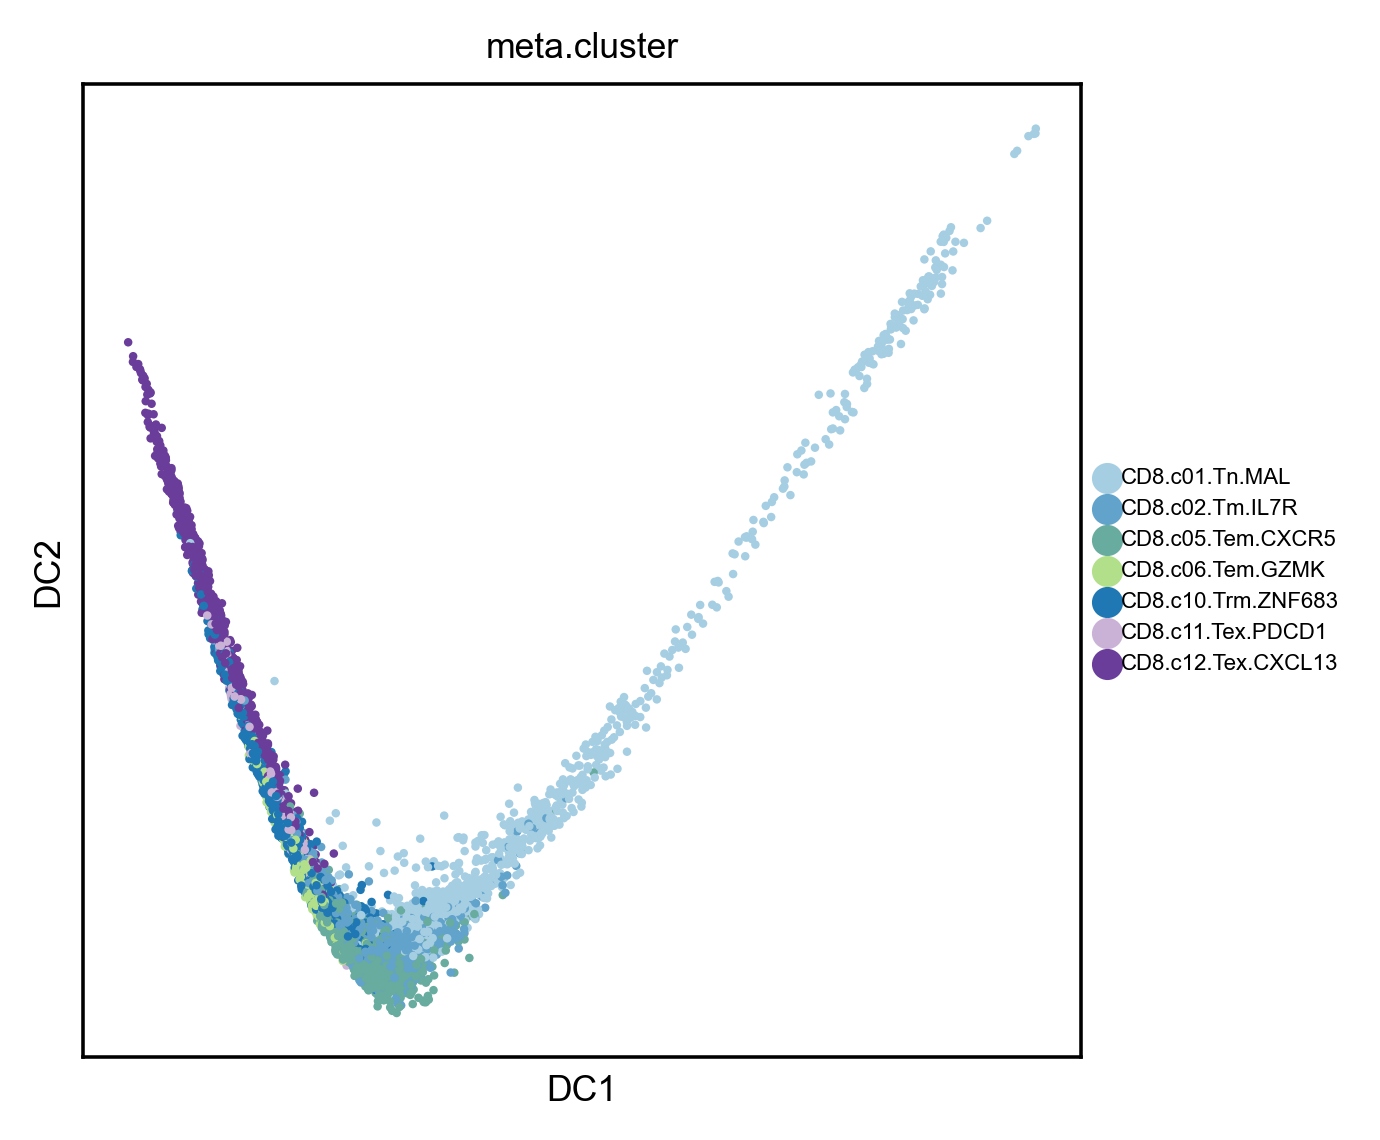

In [8]:
sc.set_figure_params(dpi=160, color_map='viridis', fontsize=8)
sc.pl.embedding(adata, basis='diffmap', color=['meta.cluster'],
                legend_loc='right margin', legend_fontsize=5,
               save=f".{stype}_Tex.pdf")

In [9]:
## DPT
#Find the stem cell with the highest DC1 value to act as root for the diffusion pseudotime and compute DPT
Tn_mask = np.isin(adata.obs['meta.cluster'], ['CD8.c01.Tn.MAL','CD4.c01.Tn.TCF7'])
min_stem_id = np.argmax(adata.obsm['X_diffmap'][Tn_mask, 1])
root_id = np.arange(len(Tn_mask))[Tn_mask][min_stem_id]
adata.uns['iroot'] = root_id
#
sc.tl.dpt(adata)

computing Diffusion Pseudotime using n_dcs=10
    finished (0:00:00)


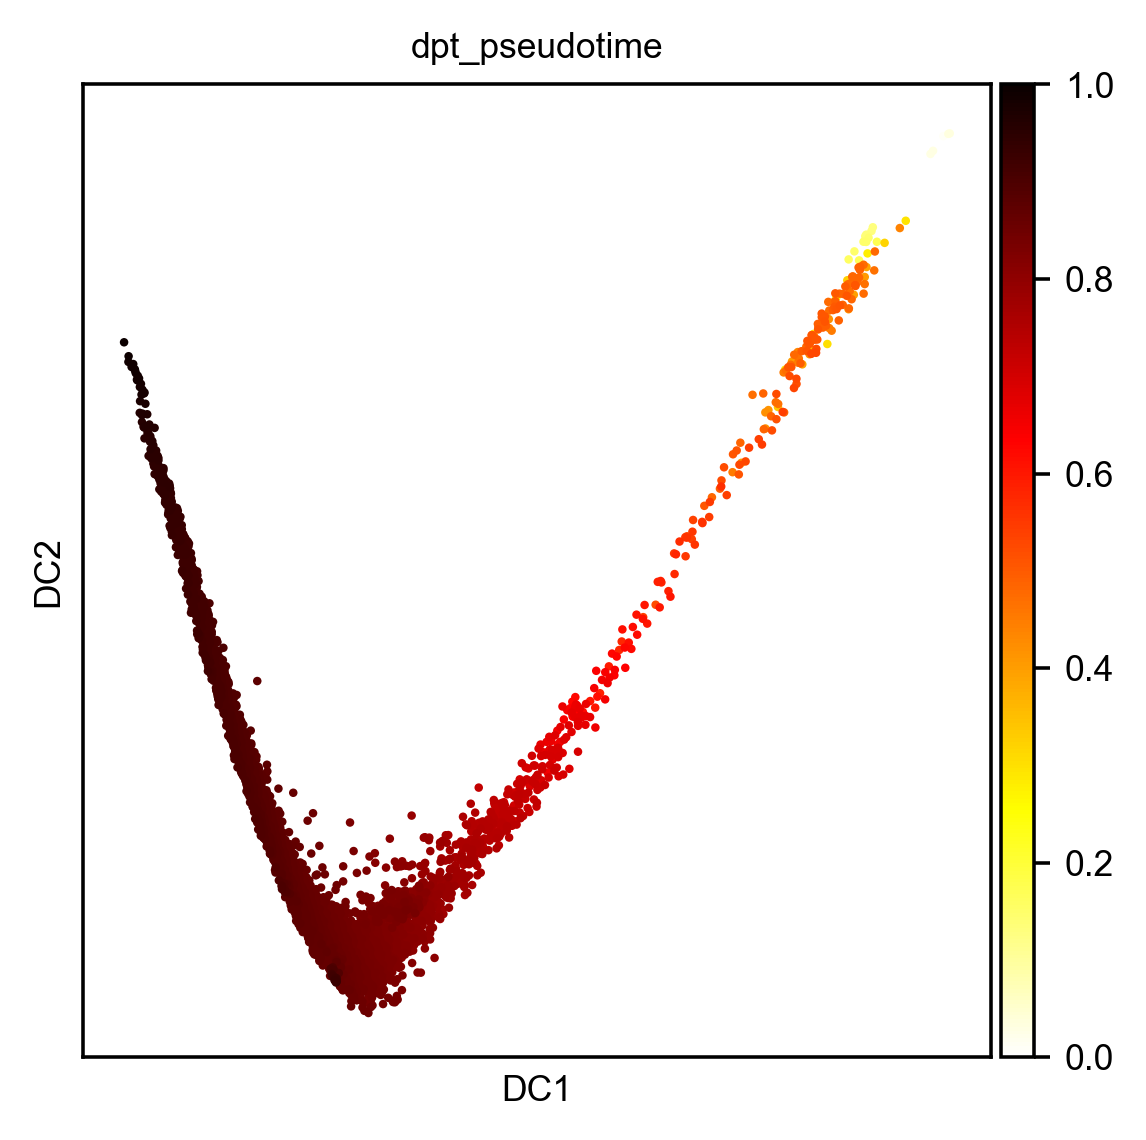

In [10]:
sc.pl.diffmap(adata, color='dpt_pseudotime', color_map="hot_r", save=f"_pseudotime.{stype}_Tex.pdf")

In [11]:
## save
adata.write(f"{oDir}/{stype}_Tex.sc.h5ad")
diff = pd.DataFrame(adata.obsm['X_diffmap'], index=adata.obs_names)
diff.to_csv(f"{oDir}/{stype}_Tex.diffMap.txt", sep="\t")
adata.obs.loc[:,["meta.cluster","dpt_pseudotime"]].to_csv(f"{oDir}/{stype}_Tex.dpt_pseudotime.txt", sep="\t")